### Генерация поэзии с помощью нейронных сетей: шаг 1
##### Автор: [Радослав Нейчев](https://www.linkedin.com/in/radoslav-neychev/), @neychev

Ваша основная задача: научиться генерироват стихи с помощью простой рекуррентной нейронной сети (Vanilla RNN). В качестве корпуса текстов для обучения будет выступать роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина.

In [1]:
# do not change the code in the block below
# __________start of block__________
import string
import os
from random import sample

import numpy as np
import torch, torch.nn as nn
import torch.nn.functional as F

from IPython.display import clear_output

import matplotlib.pyplot as plt
# __________end of block__________

In [2]:
# do not change the code in the block below
# __________start of block__________
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('{} device is available'.format(device))
# __________end of block__________

cuda device is available


#### 1. Загрузка данных.

In [3]:
# do not change the code in the block below
# __________start of block__________
!wget https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/onegin.txt

with open('onegin.txt', 'r') as iofile:
    text = iofile.readlines()

text = "".join([x.replace('\t\t', '').lower() for x in text])
# __________end of block__________

--2024-11-03 14:58:04--  https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/onegin.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 262521 (256K) [text/plain]
Saving to: ‘onegin.txt’

onegin.txt          100%[===================>] 256.37K  --.-KB/s    in 0.005s  

2024-11-03 14:58:04 (54.4 MB/s) - ‘onegin.txt’ saved [262521/262521]



#### 2. Построение словаря и предобработка текста
В данном задании требуется построить языковую модель на уровне символов. Приведем весь текст к нижнему регистру и построим словарь из всех символов в доступном корпусе текстов. Также добавим токен `<sos>`.

In [4]:
# do not change the code in the block below
# __________start of block__________
tokens = sorted(set(text.lower())) + ['<sos>']
num_tokens = len(tokens)

assert num_tokens == 84, "Check the tokenization process"

token_to_idx = {x: idx for idx, x in enumerate(tokens)}
idx_to_token = {idx: x for idx, x in enumerate(tokens)}

assert len(tokens) == len(token_to_idx), "Mapping should be unique"

print("Seems fine!")


text_encoded = [token_to_idx[x] for x in text]
# __________end of block__________

Seems fine!


__Ваша задача__: обучить классическую рекуррентную нейронную сеть (Vanilla RNN) предсказывать следующий символ на полученном корпусе текстов и сгенерировать последовательность длины 100 для фиксированной начальной фразы.

Вы можете воспользоваться кодом с занятие №6 или же обратиться к следующим ссылкам:
* Замечательная статья за авторством Andrej Karpathy об использовании RNN: [link](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)
* Пример char-rnn от Andrej Karpathy: [github repo](https://github.com/karpathy/char-rnn)
* Замечательный пример генерации поэзии Шекспира: [github repo](https://github.com/spro/practical-pytorch/blob/master/char-rnn-generation/char-rnn-generation.ipynb)

Данное задание является достаточно творческим. Не страшно, если поначалу оно вызывает затруднения. Последняя ссылка в списке выше может быть особенно полезна в данном случае.

Далее для вашего удобства реализована функция, которая генерирует случайный батч размера `batch_size` из строк длиной `seq_length`. Вы можете использовать его при обучении модели.

In [5]:
# do not change the code in the block below
# __________start of block__________
batch_size = 256
seq_length = 100
start_column = np.zeros((batch_size, 1), dtype=int) + token_to_idx['<sos>']

def generate_chunk():
    global text_encoded, start_column, batch_size, seq_length

    start_index = np.random.randint(0, len(text_encoded) - batch_size*seq_length - 1)
    data = np.array(text_encoded[start_index:start_index + batch_size*seq_length]).reshape((batch_size, -1))
    yield np.hstack((start_column, data))
# __________end of block__________

Пример батча:

In [6]:
next(generate_chunk())

array([[83, 59, 47, ..., 59,  1, 47],
       [83, 62, 50, ..., 59, 49, 53],
       [83, 56, 45, ..., 57,  7,  0],
       ...,
       [83, 75,  1, ...,  1, 58, 45],
       [83, 62,  1, ...,  0, 58, 45],
       [83, 49,  1, ..., 49, 72,  5]])

Далее вам предстоит написать код для обучения модели и генерации текста.

## 1. Создание RNN модели

Ниже пример модели с использованием Vanilla RNN:

In [ ]:
class CharRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(CharRNN, self).__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.encoder = nn.Embedding(input_size, hidden_size)
        self.rnn = nn.RNN(hidden_size, hidden_size, n_layers, batch_first=True)
        self.decoder = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden):
        input = self.encoder(input)
        output, hidden = self.rnn(input, hidden)
        output = self.decoder(output)
        return output, hidden

    def init_hidden(self, batch_size):
        return torch.zeros(self.n_layers, batch_size, self.hidden_size, device=device)

## 2. Обучение
A helper to print the amount of time passed:

In [9]:
import time, math

def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)



Реализуем функцию обучения, которая выполняет несколько эпох обучения RNN.

In [10]:
def train(model, criterion, optimizer, chunk_len=seq_length):
    model.train()
    hidden = model.init_hidden(batch_size)
    loss = 0
    data_gen = generate_chunk()
    for batch in data_gen:
        inputs = torch.tensor(batch[:, :-1], dtype=torch.int64).to(device)
        targets = torch.tensor(batch[:, 1:], dtype=torch.int64).to(device)

        optimizer.zero_grad()
        output, hidden = model(inputs, hidden.detach())
        output = output.view(-1, num_tokens)
        targets = targets.reshape(-1)
        loss = criterion(output, targets)
        loss.backward()
        optimizer.step()
    return loss.item()




Определим параметры, такие как размер словаря и скрытого слоя, оптимизатор и функцию потерь:

In [23]:
n_epochs = 2000
print_every = 100
plot_every = 10
hidden_size = 100
n_layers = 1
lr = 0.005
model = CharRNN(num_tokens, hidden_size, num_tokens, n_layers).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
loss_avg = 0

for epoch in range(1, n_epochs + 1):
    loss = train(model, criterion, optimizer)
    loss_avg += loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0


 0s (100 5%) 2.2717]
 1s (200 10%) 2.1338]
 2s (300 15%) 2.0522]
 3s (400 20%) 2.0130]
 4s (500 25%) 1.8751]
 4s (600 30%) 1.8562]
 5s (700 35%) 1.8449]
 6s (800 40%) 1.9054]
 6s (900 45%) 1.8193]
 7s (1000 50%) 1.8487]
 8s (1100 55%) 1.8739]
 8s (1200 60%) 1.8570]
 9s (1300 65%) 1.7843]
 10s (1400 70%) 1.7967]
 10s (1500 75%) 1.7898]
 11s (1600 80%) 1.7508]
 12s (1700 85%) 1.7868]
 12s (1800 90%) 1.8796]
 13s (1900 95%) 1.7157]
 14s (2000 100%) 1.7468]


В качестве иллюстрации ниже доступен график значений функции потерь, построенный в ходе обучения авторской сети (сам код для ее обучения вам и предстоит написать).

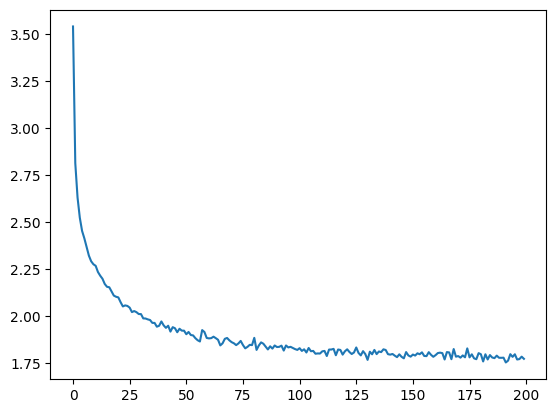

In [24]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses)

Шаблон функции `generate_sample` также доступен ниже. Вы можете как дозаполнить его, так и написать свою собственную функцию с нуля. Не забывайте, что все примеры в обучающей выборке начинались с токена `<sos>`.

In [25]:
def generate_sample(model, seed_phrase, max_length=100, temperature=1.0):
    model.eval()
    with torch.no_grad():
        input_seq = [token_to_idx['<sos>']] + [token_to_idx[ch] for ch in seed_phrase]
        input_seq = torch.tensor(input_seq, dtype=torch.int64).unsqueeze(0).to(device)
        hidden = model.init_hidden(1)
        generated = seed_phrase

        for _ in range(max_length - len(seed_phrase)):
            output, hidden = model(input_seq, hidden)
            output = output[:, -1, :] / temperature
            probabilities = F.softmax(output, dim=-1).squeeze()
            next_token = torch.multinomial(probabilities, 1).item()
            generated += idx_to_token[next_token]
            input_seq = torch.cat((input_seq, torch.tensor([[next_token]]).to(device)), dim=1)

        return generated


Пример текста сгенерированного обученной моделью доступен ниже. Не страшно, что в тексте много несуществующих слов. Используемая модель очень проста: это простая классическая RNN.

In [26]:
print(generate_sample(model, ' мой дядя самых честных правил', max_length=500, temperature=0.8))

 мой дядя самых честных правил верно, так ее спученье
а постепенье,
тречки церетский моей сенье
и в чертой
блиски чувствых и светались может быть мы надраднем, послазливы! удоморен;
но днем одна,
да него приневно,
уж оживых летой шамчать тебя ленский задорователь
тосков возвренился в тять слава;
ужел;
он рапетим,
она водой на вивлю не и уступруг спорикий.
но занятьмы
прочес рыл ради толуны уж толкнул не суприновет с одна,
в то бедной отцах,
с погих онегин вздала кажда
в завед глубокой твое высок


### Сдача задания
Сгенерируйте десять последовательностей длиной 500, используя строку ' мой дядя самых честных правил'. Температуру для генерации выберите самостоятельно на основании визуального качества генериуремого текста. Не забудьте удалить все технические токены в случае их наличия.

Сгенерированную последовательность сохрание в переменную `generated_phrase` и сдайте сгенерированный ниже файл в контест.

In [27]:
seed_phrase = ' мой дядя самых честных правил'

In [28]:
generated_phrases = [
    generate_sample(
        model,
        ' мой дядя самых честных правил',
        max_length=500,
        temperature=1.
    ).replace('<sos>', '')
    for _ in range(10)
]

In [29]:
# do not change the code in the block below
# __________start of block__________

import json
if 'generated_phrases' not in locals():
    raise ValueError("Please, save generated phrases to `generated_phrases` variable")

for phrase in generated_phrases:

    if not isinstance(phrase, str):
        raise ValueError("The generated phrase should be a string")

    if len(phrase) != 500:
        raise ValueError("The `generated_phrase` length should be equal to 500")

    assert all([x in set(tokens) for x in set(list(phrase))]), 'Unknown tokens detected, check your submission!'


submission_dict = {
    'token_to_idx': token_to_idx,
    'generated_phrases': generated_phrases
}

with open('submission_dict.json', 'w') as iofile:
    json.dump(submission_dict, iofile)
print('File saved to `submission_dict.json`')
# __________end of block__________

File saved to `submission_dict.json`


На этом задание завершено. Поздравляем!